In [11]:
import motornet as mn
from typing import Any
import torch as th
import numpy as np
import matplotlib.pyplot as plt

In [27]:
class MyCustomEnv(mn.environment.Environment):
  """A reach to a random target from a random starting position."""

  def __init__(self, *args, **kwargs):
    # pass everything as-is to the parent Environment class
    super().__init__(*args, **kwargs)
    self.__name__ = "my_custom_env"

  def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None) -> tuple[Any, dict[str, Any]]:
    self._set_generator(seed)

    options = {} if options is None else options
    batch_size: int = options.get('batch_size', 1)
    joint_state: th.Tensor | np.ndarray | None = options.get('joint_state', None)
    deterministic: bool = options.get('deterministic', False)
  
    self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})
  
    goal = self.joint2cartesian(self.effector.draw_random_uniform_states(batch_size)).chunk(2, dim=-1)[0]
    self.goal = goal if self.differentiable else self.detach(goal)
    self.elapsed = 0.
    action = th.zeros((batch_size, self.muscle.n_muscles)).to(self.device)
  
    self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
    self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
    self.obs_buffer["action"] = [action] * self.action_frame_stacking

    obs = self.get_obs(deterministic=deterministic)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": action,  # no noise here so it is the same
      "goal": self.goal,
      }
    return obs, info

  def step(self, action, deterministic: bool = False):
    self.elapsed += self.dt

    if deterministic is False:
      noisy_action = self.apply_noise(action, noise=self.action_noise)
    else:
      noisy_action = action
    
    self.effector.step(noisy_action)
    self.goal = self.goal.clone()

    obs = self.get_obs(action=noisy_action)
    reward = None
    truncated = False
    terminated = bool(self.elapsed >= self.max_ep_duration)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": noisy_action,
      "goal": self.goal,
      }
    return obs, reward, terminated, truncated, info

  def get_proprioception(self):
    mlen = self.states["muscle"][:, 1:2, :] / self.muscle.l0_ce
    mvel = self.states["muscle"][:, 2:3, :] / self.muscle.vmax
    prop = th.concatenate([mlen, mvel], dim=-1).squeeze(dim=1)
    return self.apply_noise(prop, self.proprioception_noise)

  def get_vision(self):
    vis = self.states["fingertip"]
    return self.apply_noise(vis, self.vision_noise)

  def get_obs(self, action=None, deterministic: bool = False):
    self.update_obs_buffer(action=action)

    obs_as_list = [
      self.goal,
      self.obs_buffer["vision"][0],  # oldest element
      self.obs_buffer["proprioception"][0],   # oldest element
      ]
    obs = th.cat(obs_as_list, dim=-1)

    if deterministic is False:
      obs = self.apply_noise(obs, noise=self.obs_noise)
    return obs

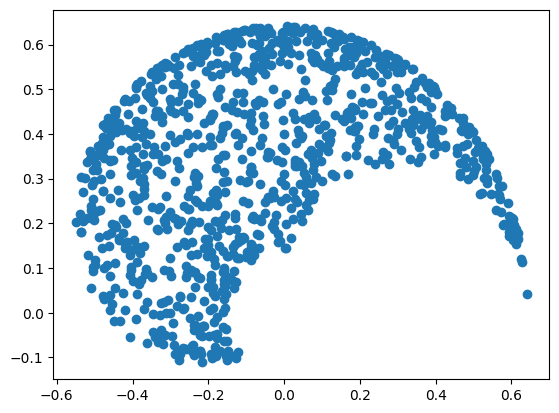

In [28]:
effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.ReluMuscle()) 
env = MyCustomEnv(effector=effector,max_ep_duration=1.,name='env')

pos = env.effector.joint2cartesian(env.effector.draw_random_uniform_states(1000)).numpy()[:, :2]
plt.scatter(pos[:, 0],pos[:, 1])

In [45]:
lb = np.array(effector.pos_lower_bound)
ub = np.array(effector.pos_upper_bound)
start_position = lb + (ub - lb) / 2
start_position = start_position.reshape(1,-1)
start_jpv = th.from_numpy(np.concatenate([start_position, np.zeros_like(start_position)], axis=1)) # joint position and velocity
start_cpv = env.effector.joint2cartesian(start_jpv).numpy()

angle = np.deg2rad(np.arange(0,360,45))
reaching_distance = 0.1
end_cp = reaching_distance * np.stack([np.cos(angle), np.sin(angle)], axis=-1)

goal_states = start_cpv + np.concatenate([end_cp, np.zeros_like(end_cp)], axis=-1)
goal_states = goal_states[:,:2]

array([[-0.05452847,  0.47647971],
       [-0.08381779,  0.54719039],
       [-0.15452847,  0.57647971],
       [-0.22523915,  0.54719039],
       [-0.25452847,  0.47647971],
       [-0.22523915,  0.40576903],
       [-0.15452847,  0.37647971],
       [-0.08381779,  0.40576903]])

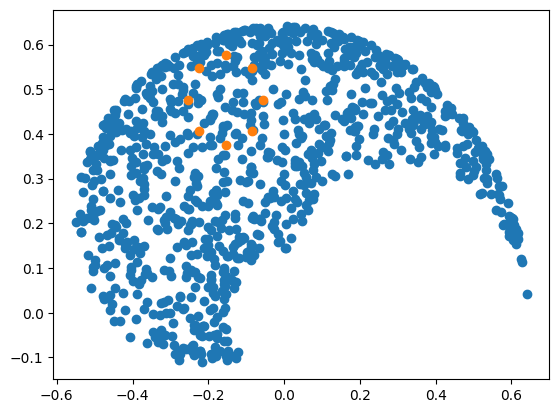

In [47]:
plt.scatter(pos[:, 0],pos[:, 1])
plt.scatter(goal_states[:, 0],goal_states[:, 1])

In [39]:
angle = np.deg2rad(np.arange(0, 360, 45))
angle = np.tile(angle_set, reps=1)
angle_set


array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714])

In [ ]:


angle_set   = np.deg2rad(np.arange(0, 360, 8))
angle       = np.tile(angle_set, reps=reps)
start_cpv   = self.network.plant.joint2cartesian(start_jpv)
end_cp      = self.reaching_distance * np.stack([np.cos(angle), np.sin(angle)], axis=-1)

In [21]:
class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        
        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            else:
                raise ValueError
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        return u, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden
    
device = th.device("cpu")

policy = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [24]:
angle_set   = np.deg2rad(np.arange(0, 360, 45))
angle_set.shape

(8,)

In [9]:
batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)

  #joint_state = th.from_numpy(np.tile(start_jpv,(batch_size,1)))

  effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.ReluMuscle()) 
  env = MyCustomEnv(effector=effector,max_ep_duration=1.,name='env')


  obs, info = env.reset(options={"joint_state": joint_state})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  loss = l1(xy, tg)  # L1 loss on position
  
  # backward pass & update weights
  optimizer.zero_grad() 
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

KeyboardInterrupt: 